# Requirements

In [1]:
from collections import Counter
from functools import wraps, reduce
import heapq
import math
from math import exp, floor, log
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import random

# Descriptive statistics

## Problem setting

Computing descriptive statistics scch as the mean and standard deviation is of course quite easy for data values $x_I$ where $i \in \[1, N\]$.  The mean value $\mu$ is given by:
$$
    \mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$
The standard deviation $\sigma$ is given by:
$$
    \sigma = \sqrt{\frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \mu)^2}
$$
However, how to compute these quantities when you can not store the actual data values?  The values come in a stream and you don't know how many will arrive in total.  Also, the number of data values may be too large to store in your computers memory.  Waht can you do?

In fact, this is not hard.  Once you realize that you need to keep track of three quantities, i.e.,
1. the number of data values so far;
1. the sum of those data values; and
1. the sum of the squares of those data values..

It is trivial to see that the mean can be computed from the number of data values and their sum, and a little algebra will convinece you that all three quantities allow you to compute the standard deviation.

We will consider three scenarios, the first based on objects, the second on coroutines, and the third purely functional.

## Object-oriented approach

We define a class with three attributes, the quantities we need to keep trakc of.  The constructor initializes these quantities.  A method `add` will update these three quantities each time a data value arrives, and three accessors methods allow us to access the number of values, the mean and the standard deviation.  For convenience, the latter three methods are properties.

In [2]:
class Stats:
    '''class to compute descriptive statistics on streaming data
    
    Example
    -------
    stats = Stats()
    for value in range(1, 6):
        stats.add(value)
    print(stats.n, stats.mean, stats.stddev)
    '''
    
    def __init__(self):
        '''constructor for Stats class'''
        self._n = 0
        self._sum = 0.0
        self._sum2 = 0.0
        
    def add(self, value):
        '''add a value to the statistics
        
        Parameters
        ----------
        value : float
            value to add
        '''
        self._n += 1
        self._sum += value
        self._sum2 += value**2
        
    @property
    def n(self):
        '''accessor for the number of values
        
        Returns
        -------
        int
            number of values added to the statistics
        '''
        return self._n
    
    @property
    def mean(self):
        '''current mean value based on added data
        
        Returns
        -------
        float
            current mean value, None if no data values were added
        '''
        if self.n > 0:
            return self._sum/self.n
    
    @property
    def stddev(self):
        '''current standard deviation based on added data
        
        Returns
        -------
        float
            current standard deviation, None if less than two data values'''
        if self.n > 1:
            return math.sqrt((self._sum2 - self._sum**2/self.n)/(self.n - 1))
        
    def __repr__(self):
        '''return a texutal representation of the object
        
        Returns
        -------
        str
            string representation of the object
        '''
        if self.n == 0:
            return f'mean = N/A, stddev = N/A, n = {self.n}'
        elif self.n == 1:
            return f'mean = {self.mean}, stddev = N/A, n = {self.n}'
        else:
            return f'mean = {self.mean}, stddev = {self.stddev}, n = {self.n}'

By way of test, compute the statistics for the numbers 1 thourgh 5.

In [3]:
stats = Stats()
print(stats.n, stats.mean, stats.stddev)
for value in range(1, 6):
    stats.add(value)
    print(stats)

0 None None
mean = 1.0, stddev = N/A, n = 1
mean = 1.5, stddev = 0.7071067811865476, n = 2
mean = 2.0, stddev = 1.0, n = 3
mean = 2.5, stddev = 1.2909944487358056, n = 4
mean = 3.0, stddev = 1.5811388300841898, n = 5


We can easily handle multiple data streams.  For instance, wee can compute statistics of odd and even numbers separately.

In [4]:
odd_stats, even_stats = Stats(), Stats()
for value in range(1, 8):
    if value % 2 == 0:
        even_stats.add(value)
    else:
        odd_stats.add(value)
    print('odd stats  -> ', odd_stats)
    print('even stats -> ', even_stats)

odd stats  ->  mean = 1.0, stddev = N/A, n = 1
even stats ->  mean = N/A, stddev = N/A, n = 0
odd stats  ->  mean = 1.0, stddev = N/A, n = 1
even stats ->  mean = 2.0, stddev = N/A, n = 1
odd stats  ->  mean = 2.0, stddev = 1.4142135623730951, n = 2
even stats ->  mean = 2.0, stddev = N/A, n = 1
odd stats  ->  mean = 2.0, stddev = 1.4142135623730951, n = 2
even stats ->  mean = 3.0, stddev = 1.4142135623730951, n = 2
odd stats  ->  mean = 3.0, stddev = 2.0, n = 3
even stats ->  mean = 3.0, stddev = 1.4142135623730951, n = 2
odd stats  ->  mean = 3.0, stddev = 2.0, n = 3
even stats ->  mean = 4.0, stddev = 2.0, n = 3
odd stats  ->  mean = 4.0, stddev = 2.581988897471611, n = 4
even stats ->  mean = 4.0, stddev = 2.0, n = 3


## Coroutines

A coroutine is a generalization of a function.  Once it is called, and can suspend its execution and wait for additional values.  In Python, this is achieved using the `yield` keyword.

The function below initializes the quantities we need to keep track of, and then runs an infinite loop and yields in each iteration to await a new value.  When it receives a value, it updates the three quantities.  When no more values are passed in, a `GeneratorExit` exception is raised, and we store the number of values, mean and standard deviation in the dictionary we passed to the function as an argument.

In [5]:
def create_coro_stats(stats):
    '''create a coroutine that keeps track of descriptive
    statistics of a data stream
    
    Parameters
    ----------
    stats : dict
        dictrionary that will hold the statistics, i.e., number of values,
        mean and standard deviation.  The dictionary will contain None for
        the mean and standard deviation if not enough values were send to
        the statistics coroutine.
        
    Example
    -------
    stats_dict = dict()
    stats = make_stats(stats_dict)
    for value in range(1, 6):
        stats.send()
    stats.close()
    '''

    n, val_sum, val_sum2 = 0, 0.0, 0.0
    try:
        while True:
            value = (yield)
            n += 1
            val_sum += value
            val_sum2 += value**2
    except GeneratorExit:
        stats['n'] = n
        stats['mean'] = val_sum/n if n > 0 else None
        stats['stddev'] = math.sqrt((val_sum2 - val_sum**2/n)/(n - 1)) if n > 1 else None

Using this is a bit tedious, but we will simplify that later on.

First we create and empty dictionary that will be passed to `create_stats` and call the function.  This results in a coroutine stored in the variable `statts`.  We "start" the coroutine by invoking Python's `next` function on it.  The function will suspend in the line with yield to wait for input.  The input is provided by calling the `send` method on it, with the new value as argument.

When all values are sent to the function, we invoke the `close` method which generates the `GeneratorExit` exception, and the coroutine finishes off by populating the dictionary.

In [6]:
stats_dict = dict()
stats = create_coro_stats(stats_dict)
next(stats)
for value in range(1, 6):
    stats.send(value)
result = stats.close()
print(stats_dict)

{'n': 5, 'mean': 3.0, 'stddev': 1.5811388300841898}


Although this is cute, having to call `next` is a bit of an inconvenience.  However, this can easily be overcome by defining a decorator.

A decorator is a function that wraps aournd another function so that that it can do one or more of
1. provide context;
1. do preprocessing; and/or
1. do postprocessing.

The decorator below takes the function that will be the coroutine as an argument, and it returns a wrapper that will create and "start" the coroutine, and finally return the latter.  The function `make_stats` is essentially the same as before, except that
1. it is wrapped using the `coroutine` decorator and
1. it updates the dictionary passed to it as soon as a new value is passed in to mimic the class' behavior we defined previously.

In [7]:
def coroutine(func):
    '''decorqtor to create and "start" a coroutine
    
    Example
    -------
    @coroutine
    def my_coroutine(a, b, c, d=17)
        ...
    '''
    @wraps(func)
    def start(*args, **kwargs):
        routine = func(*args, **kwargs)
        next(routine)
        return routine
    return start

@coroutine
def create_coro_stats(stats):
    '''create a coroutine that keeps track of descriptive
    statistics of a data stream
    
    Parameters
    ----------
    stats : dict
        dictrionary that will hold the statistics, i.e., number of values,
        mean and standard deviation.  The dictionary will contain None for
        the mean and standard deviation if not enough values were send to
        the statistics coroutine.
        
    Example
    -------
    stats_dict = dict()
    stats = make_stats(stats_dict)
    for value in range(1, 6):
        stats.send()
    stats.close()
    '''
    n, val_sum, val_sum2 = 0, 0.0, 0.0
    stats['n'] = n
    try:
        while True:
            value = (yield)
            n += 1
            val_sum += value
            val_sum2 += value**2
            stats['n'] = n
            stats['mean'] = val_sum/n
            if n > 1:
                stats['stddev'] = math.sqrt((val_sum2 - val_sum**2/n)/(n - 1))
    except GeneratorExit:
        pass

Using the coroutine is now more natural since the decorator has taken care of the creation and start of the coroutine.

In [8]:
stats_dict = dict()
stats = create_coro_stats(stats_dict)
print(stats_dict)
for value in range(1, 6):
    stats.send(value)
    print(stats_dict)
stats.close()

{'n': 0}
{'n': 1, 'mean': 1.0}
{'n': 2, 'mean': 1.5, 'stddev': 0.7071067811865476}
{'n': 3, 'mean': 2.0, 'stddev': 1.0}
{'n': 4, 'mean': 2.5, 'stddev': 1.2909944487358056}
{'n': 5, 'mean': 3.0, 'stddev': 1.5811388300841898}


You may have noted the `@wraps` decorator in the definition of the decorator `coroutine`.  This is useful to ensure that the docstring of the the wrapped funciton is shown correctly, as you can see below.

In [9]:
help(create_coro_stats)

Help on function create_coro_stats in module __main__:

create_coro_stats(stats)
    create a coroutine that keeps track of descriptive
    statistics of a data stream
    
    Params
    ------
    stats : dict
        dictrionary that will hold the statistics, i.e., number of values,
        mean and standard deviation.  The dictionary will contain None for
        the mean and standard deviation if not enough values were send to
        the statistics coroutine.
        
    Example
    -------
    stats_dict = dict()
    stats = make_stats(stats_dict)
    for value in range(1, 6):
        stats.send()
    stats.close()



As in the object oriented approach, we can easily handle multiple data streams with coroutines as well.  For instance, wee can compute statistics of odd and even numbers separately.

In [10]:
odd_stats_dict, even_stats_dict = dict(), dict()
odd_stats, even_stats = create_coro_stats(odd_stats_dict), create_coro_stats(even_stats_dict)
for value in range(1, 8):
    if value % 2 == 0:
        even_stats.send(value)
    else:
        odd_stats.send(value)
    print('odd stats  -> ', odd_stats_dict)
    print('even stats -> ', even_stats_dict)
odd_stats.close()
even_stats.close()

odd stats  ->  {'n': 1, 'mean': 1.0}
even stats ->  {'n': 0}
odd stats  ->  {'n': 1, 'mean': 1.0}
even stats ->  {'n': 1, 'mean': 2.0}
odd stats  ->  {'n': 2, 'mean': 2.0, 'stddev': 1.4142135623730951}
even stats ->  {'n': 1, 'mean': 2.0}
odd stats  ->  {'n': 2, 'mean': 2.0, 'stddev': 1.4142135623730951}
even stats ->  {'n': 2, 'mean': 3.0, 'stddev': 1.4142135623730951}
odd stats  ->  {'n': 3, 'mean': 3.0, 'stddev': 2.0}
even stats ->  {'n': 2, 'mean': 3.0, 'stddev': 1.4142135623730951}
odd stats  ->  {'n': 3, 'mean': 3.0, 'stddev': 2.0}
even stats ->  {'n': 3, 'mean': 4.0, 'stddev': 2.0}
odd stats  ->  {'n': 4, 'mean': 4.0, 'stddev': 2.581988897471611}
even stats ->  {'n': 3, 'mean': 4.0, 'stddev': 2.0}


Although this looks somewhat like a functional approach, it is not.  The dictionary that is passed in when creating the coroutine is modified, so this is a side-effect, and hence not purely functional.

## Functional approach

The decorators `coroutine` and `warps` that were used in the previous section are examples of higher-order functions, i.e., functions that
1. have functions as arguments (boring...) and/or
1. return functions.

Can we use functions that return functions to compute descriptive statistics on data streams?  Yes, we can.

In [11]:
def create_functional_stats():
    '''create a function to compute descritive statistics on data streams
    
    Example
    -------
    stats = create_functional_stats()
    for value in range(1, 6):
        n, mean, stddev = stats(value)
    '''
    n, val_sum, val_sum2 = 0, 0.0, 0.0
    
    def stats_func(value):
        nonlocal n, val_sum, val_sum2
        n += 1
        val_sum += value
        val_sum2 += value**2
        return n, val_sum/n if n > 0 else None , math.sqrt((val_sum2 - val_sum**2/n)/(n - 1)) if n > 1 else None
    
    return stats_func

The function  `create_functional_stats` provides the context for `stats_func` that uses the variables `n`, `val_sum` and `val_sum2` in its enclosing scope to store the current state.  Each call to the function will update the state appropriately.

In [12]:
stats = create_functional_stats()
for value in range(1, 8):
    print(stats(value))

(1, 1.0, None)
(2, 1.5, 0.7071067811865476)
(3, 2.0, 1.0)
(4, 2.5, 1.2909944487358056)
(5, 3.0, 1.5811388300841898)
(6, 3.5, 1.8708286933869707)
(7, 4.0, 2.160246899469287)


And again, we can easily handle multiple data streams.  For instance, wee can compute statistics of odd and even numbers separately.

In [13]:
odd_stats, even_stats = create_functional_stats(), create_functional_stats()
for value in range(1, 8):
    if value % 2 == 0:
        print('even stats -> ', even_stats(value))
    else:
        print('odd stats  -> ', odd_stats(value))

odd stats  ->  (1, 1.0, None)
even stats ->  (1, 2.0, None)
odd stats  ->  (2, 2.0, 1.4142135623730951)
even stats ->  (2, 3.0, 1.4142135623730951)
odd stats  ->  (3, 3.0, 2.0)
even stats ->  (3, 4.0, 2.0)
odd stats  ->  (4, 4.0, 2.581988897471611)


But is this really a functional approach?  Strictly speaking, no.  Functional programming is supposed to be side-effect free, but our function in fact has state that evolves over time.

The following class forms the basis for a real functional implementation.

In [14]:
class FunctionalStats:
    
    def __init__(self, sum_value: float=0.0, sum2: float=0.0, n: int=0):
        '''constructor for Stats objects
        
        Parameters
        ----------
        Either none, which initializes an object that has seen no data yet, or
        
        sum_value: float
            the sum of the values up to this point
        sum2: float
            the sum of the squares of the values up to this point
        n: int
            the number of values up to this point
        '''
        self._sum = sum_value
        self._sum2 = sum2
        self._n = n
        
    @property
    def n(self):
        '''Number of values seen by this object
        
        Returns
        -------
        int
            number of data values seen so far
        '''
        return self._n
    
    @property
    def mean(self):
        '''Mean value of the data values seen so far
        
        Returns
        -------
        float
            mean value
            
        Raises
        ------
        ValueError
            Exception when the number of values is less than 1
        '''
        if self._n < 1:
            raise ValueError('at least one data value required for mean')
        return self._sum/self._n
    
    @property
    def stddev(self):
        '''Standard deviation of the data values seen so far
        
        Returns
        -------
        float
            standard deviation

        Raises
        ------
        ValueError
            Exception when the number of values is less than 1
            
        '''
        if self._n < 2:
            raise ValueError('at least two data values required for standard deviation')
        return math.sqrt((self._sum2 - self._sum**2/self._n)/(self._n - 1))
    
    def __add__(self, value: float):
        '''functional operator, creates a new Stats object when a value is added
           called as stats + value
        
        Parameters
        ----------
        value: float
            new data value to be added to the statistics
            
        Returns
        -------
        Stats
            a new Stats object that includes the value just added
        '''
        return FunctionalStats(sum_value=self._sum + value, sum2=self._sum2 + value**2, n=self._n + 1)
    
    def __iadd__(self, value: float):
        '''non-functional operator, updates the Stats object when a value is added
        
        Parameters
        ----------
        value: float
            new data value to be added to the statistics
            
        Returns
        -------
        Stats
            updated Stats object including the value just added, called as
            stats += value
        '''
        self._sum += value
        self._sum2 += value**2
        self._n += 1
        return self
        
    def __repr__(self):
        '''return a texutal representation of the object
        
        Returns
        -------
        str
            string representation of the object
        '''
        if self.n == 0:
            return f'mean = N/A, stddev = N/A, n = {self.n}'
        elif self.n == 1:
            return f'mean = {self.mean}, stddev = N/A, n = {self.n}'
        else:
            return f'mean = {self.mean}, stddev = {self.stddev}, n = {self.n}'

To illustrate that using the `+` operator is truly side-effect free, we can sotre all the intermediate objects n a list, and print them when done.

In [15]:
values = [3.1, 5.2, 7.3]

In [16]:
all_stats = [FunctionalStats()]
for value in values:
    all_stats.append(all_stats[-1] + value)

In [17]:
for stats in all_stats:
    print(stats)

mean = N/A, stddev = N/A, n = 0
mean = 3.1, stddev = N/A, n = 1
mean = 4.15, stddev = 1.4849242404917493, n = 2
mean = 5.2, stddev = 2.0999999999999974, n = 3


On the other hand, using the `+=` operator which is non-functional shows that indeed the object is updated.

In [18]:
all_stats = [FunctionalStats()]
for value in values:
    stats = all_stats[-1]
    stats += value
    all_stats.append(stats)

In [19]:
for stats in all_stats:
    print(stats)

mean = 5.2, stddev = 2.0999999999999974, n = 3
mean = 5.2, stddev = 2.0999999999999974, n = 3
mean = 5.2, stddev = 2.0999999999999974, n = 3
mean = 5.2, stddev = 2.0999999999999974, n = 3


Note that is now trivial to use this `Stats` object in a reduction.

In [20]:
reduce(operator.add, values, FunctionalStats())

mean = 5.2, stddev = 2.0999999999999974, n = 3

## Performance

Is there a performance difference between the three implementations?

In [21]:
values = [random.random() for _ in range(1_000_000)]

In [22]:
%%timeit
stats = Stats()
for value in values:
    stats.add(value)

304 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
stats_dict = dict()
stats = create_coro_stats(stats_dict)
for value in values:
    stats.send(value)
stats.close()

516 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
stats = create_functional_stats()
for value in values:
    stats(value)

373 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
stats = FunctionalStats()
for value in values:
    stats = stats + value

465 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit reduce(operator.add, values, FunctionalStats())

456 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
stats = FunctionalStats()
for value in values:
    stats += value

315 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit reduce(operator.iadd, values, FunctionalStats())

303 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Conclusion

It is immediately clear that the "not really" funcitonal approach is ridiculously easy, once you wrap your head around it.  Up to that time, the object oriented approach might be more intuitive.

The true functional approach is definitely the slowest verion by some margin, but it is of course the cleanest since it is side-effect free.

Coroutines seems the hardest to do, although they are intuitevely easy to understand, the mechanics to get them to work are somewhat cumbersome.  However, they have nice applications when creating data pipelines.

The object oriented approach has a better performance, but only by 5 %.

Overloading the `+=` operator gives the best performance by quite some margin.

# Median

To compute the median, you need access to all data values simultaneously, so there are memory restrictions to what can be done.  However, computing a running meidan is a quite intesting problem.  For a list of values $x_i$ for $i \in [1, N]$, sort the list.  The median is defined as
1. the middle element if $N$ is odd,
1. the average of the two middle elements when $N$ is even.

The idea is to split the data into two groups, those values less than the current median (small), and those larger than or equal to that value (large).  To compute the median we need:
* the maximum of the small values,
* the minimum of the large set, or
* both.

So we need a data structure that makes it easy (i.e., cheap) to obtain the minimum value, and that is reasonably cheap to update.  A heap is very suited to this.

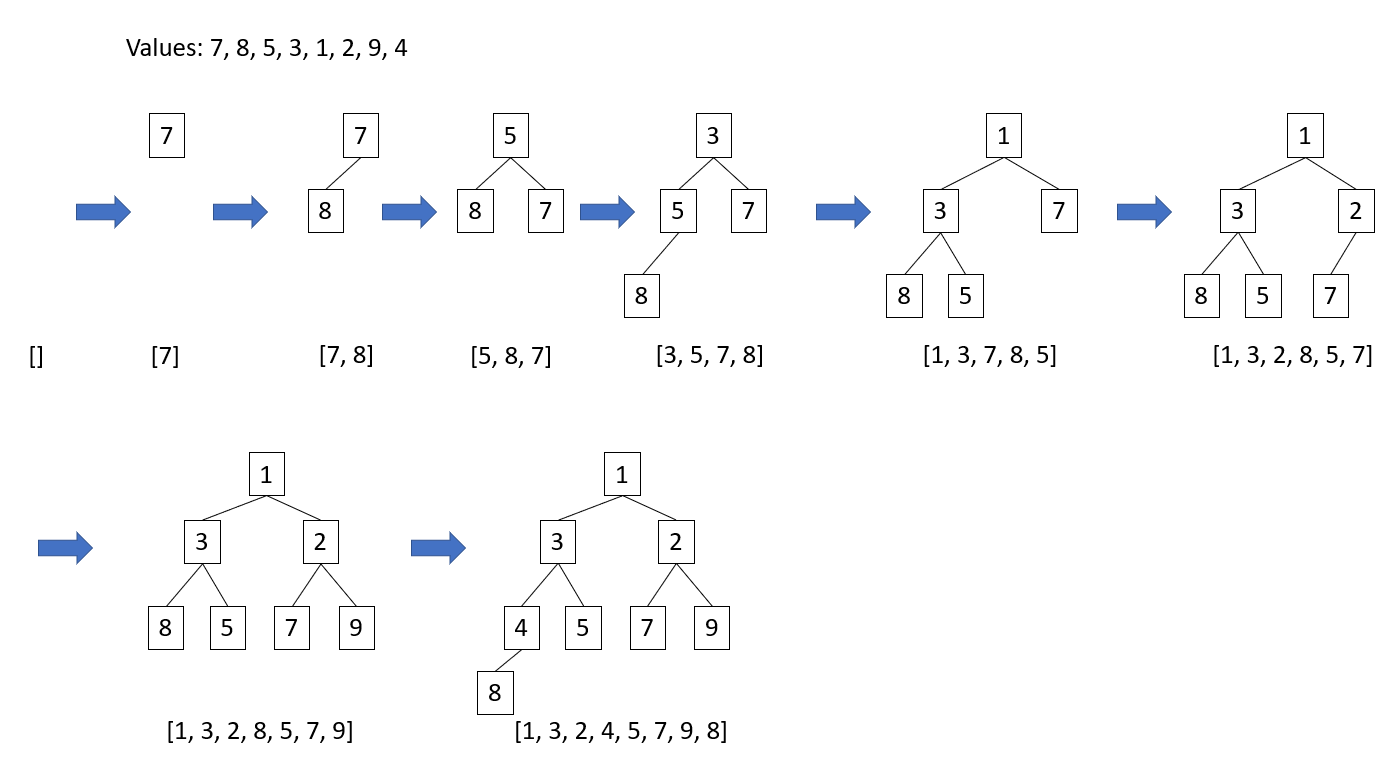

The code below illustrates the use of the `heapq` module to build up a heap.

In [29]:
heap = []
for value in [7, 8, 5, 3, 1, 2, 9, 4]:
    heapq.heappush(heap, value)
    print(heap)

[7]
[7, 8]
[5, 8, 7]
[3, 5, 7, 8]
[1, 3, 7, 8, 5]
[1, 3, 2, 8, 5, 7]
[1, 3, 2, 8, 5, 7, 9]
[1, 3, 2, 4, 5, 7, 9, 8]


The standard library module `heapq` helps here, however, we need to be a little creative by storing negated values for the small values, and juggling the signs as required to keep things consistent.

In [30]:
class RunningMedian:
    '''class to meintain a running median for data taht is added value
    by value.
    
    Example
    -------
    running_median = RunningMedian()
    for value in values:
        running_meidan.add(value)
        print(running_median.median)
    '''
    
    def __init__(self):
        '''constructor for the RunningMedian class'''
        self._small_heap = list()
        self._large_heap = list()
        self._median = None
        
    def add(self, value):
        '''method to add a value to the running median
        
        Parameters
        ----------
        value : float
            value to be added
        '''
        if self._median is None:
            heapq.heappush(self._large_heap, value)
        else:
            if value < self._median:
                heapq.heappush(self._small_heap, -value)
            else:
                heapq.heappush(self._large_heap, value)
            self._balance()
        self._update_median()
    
    @property
    def median(self):
        '''accessor method to get the current median value for the data
        that has been processed up to this point
        
        Returns
        -------
        float
            median value
        '''
        return self._median
    
    def _update_median(self):
        '''private method to update the current value of the median'''
        if len(self._small_heap) < len(self._large_heap):
            self._median = self._large_heap[0]
        elif len(self._large_heap) < len(self._small_heap):
            self._median = -self._small_heap[0]
        elif len(self._small_heap) > 0:
            self._median = (self._large_heap[0] - self._small_heap[0])/2
        
    def _balance(self):
        '''private method to update the heaps, ensuring that the difference
        of their size differs by no more than 1
        '''
        if len(self._small_heap) < len(self._large_heap) - 1:
            to_move = heapq.heappop(self._large_heap)
            heapq.heappush(self._small_heap, -to_move)
        elif len(self._large_heap) < len(self._small_heap) - 1:
            to_move = heapq.heappop(self._small_heap)
            heapq.heappush(self._large_heap, -to_move)

In [31]:
running_median = RunningMedian()
values =  [random.randint(1, 50) for _ in range(10)]
for i, value in enumerate(values):
    running_median.add(value)
    print(sorted(values[:i + 1]), ' -> ', running_median.median)

[32]  ->  32
[32, 37]  ->  34.5
[17, 32, 37]  ->  32
[3, 17, 32, 37]  ->  24.5
[3, 3, 17, 32, 37]  ->  17
[3, 3, 17, 32, 37, 49]  ->  24.5
[3, 3, 17, 28, 32, 37, 49]  ->  28
[3, 3, 17, 26, 28, 32, 37, 49]  ->  27.0
[3, 3, 17, 26, 28, 32, 37, 41, 49]  ->  28
[3, 3, 17, 26, 28, 32, 37, 41, 41, 49]  ->  30.0


What is the aggregated runtime to get the running median after $N$ values have been added?

# Reservoir sampling

The class below implements a reservoir sampler.  Data is added value by value and it will probabilistically replace values in the sample by incoming values.  To save time (well, computations), we can observe that the sampling index is distributed according to a geometric distribution.  Hence we sample the next index to be added to the sample from such a distribution, which is based on the sample size.

The next index to be sampled is computed and stored in `self._next`, when `self._i`, the index of the current value, is equal to it, it replaces a value in the current sample, and the next index is computed.

In [32]:
class ReservoirSampler:
    
    def __init__(self, sample_size):
        self._sample = list()
        self._size = sample_size
        self._w = exp(log(random.random())/sample_size)
        self._i = sample_size
        self._next = self._size + floor(log(random.random())/log(1.0 - self._w))
        # print(self._w, self._next)
       
    @property
    def sample(self):
        return self._sample.copy()
    
    @property
    def sample_size(seslf):
        return self._size
    
    def add(self, value):
        if len(self._sample) < self._size:
            self._sample.append(value)
        else:
            if self._i == self._next:
                self._sample[random.randrange(0, self._size)] = value
                self._w *= exp(log(random.random())/self._size)
                self._next = self._i + 1 + floor(log(random.random())/log(1.0 - self._w))
            self._i += 1

We can test this by sampling from a sequence of distinct values many times, and check whether all possbile samples occur, and their distribution is uniform.

In [33]:
nr_values = 10
sample_size = 5
nr_samples = 100_000
values = list(range(nr_values))
counter = Counter()
for _ in range(nr_samples):
    sampler = ReservoirSampler(sample_size)
    for value in values:
        sampler.add(value)
    counter[frozenset( sampler.sample)] += 1

For a sample size of 5 out of 10 values, the number of distinct samoles is:

In [34]:
math.comb(10, 5)

252

Lo and behold, the number of distinct samples collected by reservoir sampling is the same, so all samples occur at least once.

In [35]:
len(counter)

252

In [36]:
math.comb(10, 5)

252

The distribution of the samples is given below.

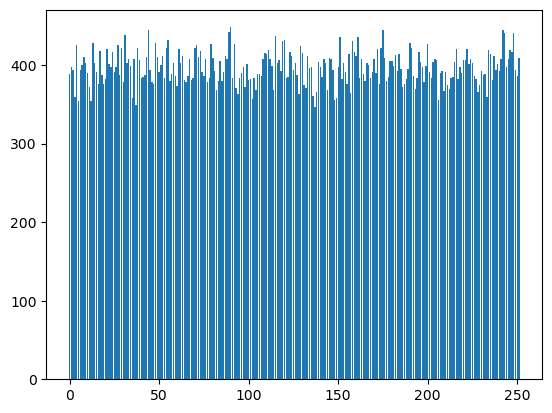

In [37]:
_ = plt.bar(x=range(len(counter)), height=counter.values())

In [38]:
min(counter.values()), max(counter.values())

(347, 448)

Can you implement a generator for the sample indices?